In [105]:
# from NS_source import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
import pandas as pd
import numpy as np
from numpy import exp
from numpy.linalg import lstsq
from scipy.optimize import minimize
from scipy.optimize import fsolve
import warnings
warnings.filterwarnings("ignore")

In [106]:
df = pd.read_csv('/Users/ryanlucas/Desktop/Bond Data - CSV.csv', index_col = "Unnamed: 0")
df['Weeks to Maturity'] = df["Days to Maturity"]/7
df["Tenor Number"] = [4, 8, 12, 24, 1*52, 2*52, 3*52, 5*52, 7*52, 10*52, 20*52, 30*52]
df

,Tenor,CUSIP,Description,Maturity Date,Price,Yield,Source,Update,Days to Maturity,Market Price,Coupon,Years to Maturity,Weeks to Maturity,Tenor Number
0,1M,912796R9@BGN Govt,B 0 02/22/22 Govt,22/02/2022,0.0313,0.0317,BGN,26/01/2022,27,99.9976,0.00,0.083333,3.857143,4
1,2M,912796S9@BGN Govt,B 0 03/22/22 Govt,22/03/2022,0.0838,0.0849,BGN,26/01/2022,55,99.9870,0.00,0.166667,7.857143,8
2,3M,912796P3@BGN Govt,B 0 04/28/22 Govt,28/04/2022,0.1925,0.1953,BGN,26/01/2022,92,99.9501,0.00,0.250000,13.142857,12
3,6M,912796S5@BGN Govt,B 0 07/28/22 Govt,28/07/2022,0.3988,0.4051,BGN,26/01/2022,183,99.7941,0.00,0.500000,26.142857,24
4,1Y,912796S3@BGN Govt,B 0 01/26/23 Govt,26/01/2023,0.6938,0.7071,BGN,26/01/2022,365,99.2831,0.00,1.000000,52.142857,52
5,2Y,91282CDV@BGN Govt,T 0 ⅞ 01/31/24 Govt,31/01/2024,99.4512,1.1534,BGN,26/01/2022,735,99.4512,0.88,2.000000,105.000000,104
6,3Y,91282CDS@BGN Govt,T 1 ⅛ 01/15/25 Govt,15/01/2025,99.1992,1.4015,BGN,26/01/2022,1085,99.1992,1.13,3.000000,155.000000,156
7,5Y,912828Z7@BGN Govt,T 1 ½ 01/31/27 Govt,31/01/2027,99.1133,1.6853,BGN,26/01/2022,1831,99.1133,1.50,5.000000,261.571429,260
8,7Y,91282CDP@BGN Govt,T 1 ⅜ 12/31/28 Govt,31/12/2028,97.0547,1.8297,BGN,26/01/2022,2531,97.0547,1.38,7.000000,361.571429,364
9,10Y,91282CDJ@BGN Govt,T 1 ⅜ 11/15/31 Govt,15/11/2031,95.6172,1.8664,BGN,26/01/2022,3580,95.6172,1.38,10.000000,511.428571,520


**Data Visualisation of original Yield Curve**

Text(0.5, 1.0, 'Original Yield Curve')

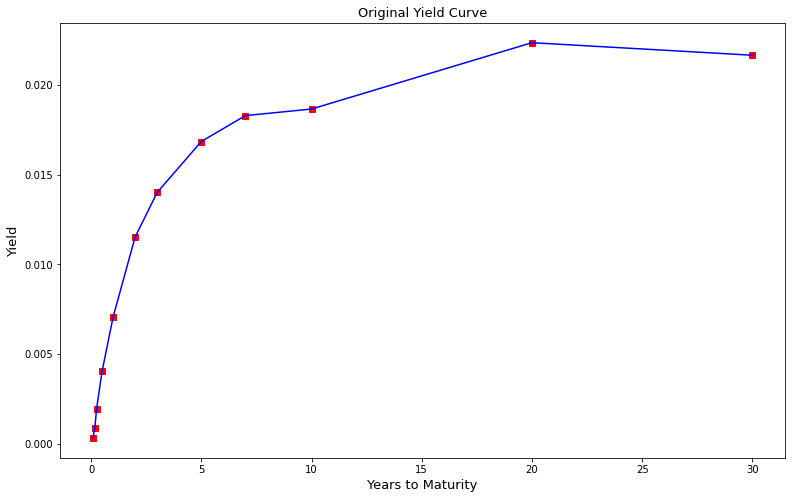

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 8)
ax.plot(df['Years to Maturity'], df['Yield']/100,'rs',df['Years to Maturity'], df['Yield']/100,'b')
ax.set_ylabel("Yield", fontsize = 13)
ax.set_xlabel("Years to Maturity", fontsize = 13)
ax.set_title("Original Yield Curve", fontsize = 13)

**Firstly, we need to construct the Nelson-Siegel factors according to the following formula:**

$$F_{\beta_1}(t)= \frac{1 - \exp(-\frac{t}{\tau})}{\frac{t}{\tau}}, \quad F_{\beta_2}(t) = \frac{1 - \exp(-\frac{t}{\tau})}{\frac{t}{\tau}} - \exp(-\frac{t}{\tau})$$

**These factors represent level, slope and curvature (also known as contango)**

In [108]:
def nelson_siegel_factors(t, tau):
    noise = np.random.normal(0, 1)*0.00000000015

    zero_maturity = t <= 0
    t[zero_maturity] = noise
    factor_beta_1 = (1 - exp(-t/tau)) / (t / tau)
    factor_beta_2 = factor_beta_1 - exp(-t/tau)

    t[zero_maturity] = 0
    factor_beta_1[zero_maturity] = 1
    factor_beta_2[zero_maturity] = 0

    return factor_beta_1, factor_beta_2


def collection_of_factors(t, tau):
    factor_beta_1, factor_beta_2 = nelson_siegel_factors(t, tau)
    const = np.ones(len(t))
    return np.stack([const, factor_beta_1, factor_beta_2]).transpose()


In [109]:
def zero_rates(t, beta_0, beta_1, beta_2, tau):
    factor_beta_1, factor_beta_2 = nelson_siegel_factors(t, tau)
    return beta_0 + beta_1*factor_beta_1 + beta_2*factor_beta_2

In [110]:
def sum_of_squared_resids(tau, t, y):
    curve, lstsq_res = get_spot_rate_iteration(tau, t, y)
    return np.sum((curve - y)**2)

**The idea is to perform least squares minimisation over the parameters corresponding to these factors in order to minimise the distance between the factor-constructed curve and the original yields. This corresponds to the following optimisation:**

$$s(0, t) = \beta_0 + \beta_1 \Bigg [ \frac{1 - \exp(-\frac{t}{\tau})}{\frac{t}{\tau}} \Bigg ] + \beta_2 \Bigg [ \frac{1 - \exp(-\frac{t}{\tau})}{\frac{t}{\tau}} - \exp(-\frac{t}{\tau}) \Bigg ]$$

$$\argmin_{\beta_0, \beta_1, \beta_2, \tau} \sum_{i = 1}^{n} \Bigg  (  y - S(0, t) \Bigg)^2$$

In [111]:
def get_spot_rate_iteration(tau, t, y):
    factors = collection_of_factors(t, tau)
    lstsq_res = lstsq(factors, y, rcond=None)
    beta_0, beta_1, beta_2 = lstsq_res[0]
    return zero_rates(t, beta_0, beta_1, beta_2, tau), lstsq_res

def ols_nelson_siegel(t, y, tau):
    opt_res = minimize(sum_of_squared_resids, x0=tau, args=(t, y))
    curve, lstsq_res = get_spot_rate_iteration(opt_res.x[0], t, y)
    beta_0, beta_1, beta_2 = lstsq_res[0]
    return beta_0, beta_1, beta_2, float(opt_res.x)

**Implementation: using Nelson-Siegel optimisation functions above to find beta's and tau**

In [156]:
y = np.array(df['Yield']/100)
t = np.array(df['Weeks to Maturity'])
ns_source_test = ols_nelson_siegel(t, y, tau=1.0)
beta_0 = ns_source_test[0]
beta_1 = ns_source_test[1]
beta_2 = ns_source_test[2]
tau_1 = ns_source_test[3]

**Plotting Nelson-Siegel curve and using a function to find yields on a given week**

Text(0.5, 1.0, 'Nelson-Siegel Yield Curve')

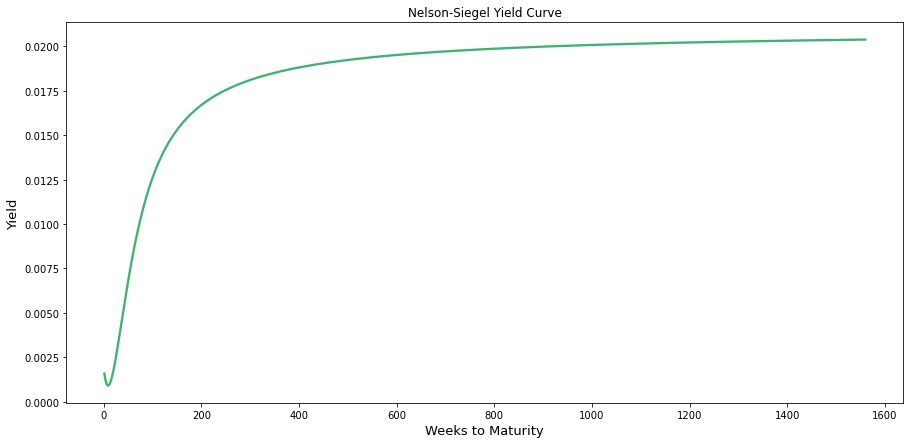

In [163]:

weeks = np.arange(0, 30*52+1, 1)
ns_yields = []

fig, ax = plt.subplots()

fig.set_size_inches(15, 7)

for i in range(len(weeks)):

    array = beta_0 + beta_1*((1-np.exp(-i/tau_1))/(i/tau_1))+beta_2*(((1-np.exp(-i/tau_1))/(i/tau_1))-(np.exp(-i/tau_1))) # tracing out the curve
    ns_yields.append(array)


curve = plot(weeks,ns_yields, color = 'mediumseagreen', linewidth =2.3 )

ax.set_ylabel("Yield", fontsize = 13)
ax.set_xlabel("Weeks to Maturity", fontsize = 13)
ax.set_title("Nelson-Siegel Yield Curve")

In [114]:
def find_point(weeks_to_maturity, curve):

    '''
    Function to find the yield corresponding to a given week
    '''

    wtm = "Weeks to Maturity:",curve[0].get_xdata()[weeks_to_maturity]
    y = "Yield:",curve[0].get_ydata()[weeks_to_maturity]
    return y, wtm

**Bond Pricing**

$$P(y, m, n) = \sum_{i \in I} \frac{c}{(1+y/m)^i} + \frac{F}{(1+y/m)^{mn}}, I \; \text{is the set of coupon payment weeks}$$

**where $y$ is the designated yield, $m$ is the payment frequency (number of payments per year) and $n$ is the number of years (rounded down to nearest half year)**

In [164]:
def get_price_from_yield(y, F, m, c, n):

    coupon_repayments = 0

    for i in range(1, m*n+1):
        coupon_repayments += c/(1+ y/m)**i
    
    final_payment = F/(1+ y/m)**(m*n)

    return coupon_repayments + final_payment

**Price for a hypothetical semi-annual coupon bond with one year two weeks to maturity and a coupon rate of 10%.**

In [116]:
one_y_two_w = find_point(54, curve)[0][1] # Finding the 54th week yield on the graph

In [117]:
yield_curve_one_y_two_w = get_price_from_yield(y = one_y_two_w, F = 100, m = 2, c = 5, n = 1)

In [169]:
print("Price one year two week bond: " + str(yield_curve_one_y_two_w))

Price one year two week bond: 109.2003091441666


**Price for a hypothetical semi-annual floating-rate coupon bond with two years three months to maturity. The floating coupon rate is tied to the six-month LIBOR interest rate**

In [170]:
LIBOR_yield = 0.464/2/100

In [171]:
print("LIBOR Yield: " + str(LIBOR_yield))

LIBOR Yield: 0.00232


In [119]:
two_y_three_m = find_point(2*52 + 4*3, curve)[0][1]

In [226]:
yield_curve_two_y_three_m = get_price_from_yield(y = two_y_three_m, F = 100, m = 2, c = LIBOR_yield*100, n = 2)

In [227]:
print("Price two year three month floating rate bond: " + str(yield_curve_two_y_three_m))

Price two year three month floating rate bond: 98.21719068444172


**Duration Calculation**

<!-- $$\frac{\sum_{k=1}^n PV_k}{P} \times t_k$$ -->

$$D(y, F, m, c, n) = \frac{ \sum_{k = 1}^{n-1} \frac{c_k}{(1+y/m)^k} (\frac{k}{m})}{\sum_{k = 1}^{n-1}\frac{c_k}{(1+y/m)^k}} +  \frac{\frac{F+c_n}{(1+y/m)^n} (\frac{n}{m})}{\frac{c_n}{(1+y/m)^n}}$$

**where $y$ is the designated yield, F is the face value, m is the payment-frequency (times per year), c is the coupon and n is the number of payment periods.**

*Note: $n$ differs from the pricing formula. $n$ is periods here and years for pricing*.

In [261]:
def get_duration(y, F, m, c, n):

    numerator = 0
    denominator = 0

    for k in range(1, n+1):

        if k == n:
            c = F + c

        numerator += (c / (1 + y/m)**k) * (k/m)
        denominator += (c / (1 + y/m)**k)

    return numerator/denominator

**Duration for a hypothetical semi-annual coupon bond with one year two weeks to maturity and a coupon rate of 10%.**

In [262]:
get_duration(one_y_two_w, F = 100, m = 2, c = 5, n = 2)

0.9771916001348062

**Duration for a hypothetical semi-annual floating-rate coupon bond with two years three months to maturity. The floating coupon rate is tied to the six-month LIBOR interest rate**

In [263]:
get_duration(two_y_three_m, F = 100, m = 2, c = LIBOR_yield*100, n = 4)

1.9929937853568667

# Bootstrapping

*Note: We are assuming maturities follow calendar structure (may not necessarily be 100% accurate relative to days to maturity, especially for short maturities)*

In [230]:
df['Tenor time'] = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]
df['Tenor time'] = [i*52 for i in df["Tenor time"]] # And in weeks

**Setting up full repayment schedule including all half-years from one year onwards**

In [231]:
maturities_list = [1/12, 2/12, 3/12, 6/12, 1]
maturities_list += np.arange(1.5, 30.5, 0.5).tolist()
maturities_df = pd.DataFrame(maturities_list, columns = ['Maturity'])*52 # In weeks again

In [232]:
coupons_full_list = []
coupons = iter([value for value in df['Coupon'] if value != 0])

for row in range(len(maturities_df)):
    if maturities_df.loc[row, 'Maturity'] in list(df["Tenor time"].iloc[5:]):
        maturities_df.loc[row, "Coupon"] = next(coupons)
    else:
        maturities_df.loc[row, "Coupon"] = 0

In [233]:
Prices_full_list = []
Prices = iter([value for value in df['Market Price'] if value != 0])

for row in range(len(maturities_df)):
    if maturities_df.loc[row, 'Maturity'] in list(df["Tenor time"].iloc[5:]):
        maturities_df.loc[row, "Market Price"] = next(Prices)
    else:
        maturities_df.loc[row, "Market Price"] = 0

In [234]:
maturities_df['Price'] = 0
maturities_df['Rate'] = 0

**Converting from yield-to-maturity to spot rate for zero-coupond bonds**

$$S(P, m, F) = (\frac{F}{P})^{1/m} - 1$$

where $P$ is the market price, $m$ is the time-to-maturity and $F$ is the face value of the bond.

In [235]:
def zero_coupon_spot_rate(market_price, tt_maturity, F= 100):
    spot_rate = ((F/market_price)**(1/tt_maturity) - 1) 
    return spot_rate

In [236]:
spot_rates = []
for i in range(5):
    spot_rates.append(zero_coupon_spot_rate(df['Market Price'].iloc[i], df['Years to Maturity'].iloc[i]))

In [237]:
spot_rates = spot_rates + [0 for i in range(len(maturities_df) -5)]

In [238]:
maturities_df['Rate'] = spot_rates

**Removing the zero-coupon rates that aren't included in the pricing formula**

In [239]:
maturities_df = maturities_df[3:].reset_index(drop = True)

**The fun begins...**

**We use linear interpolation to find missing spot (discount) rates that lie between our given US treasury bonds**

In [240]:
def  linear_interpolation(t_prime, t, T, s_t, s_T):
    numerator = (T - t_prime)*s_t + (t_prime-t)*s_T
    denominator = T - t
    return numerator/denominator

In [241]:
global maturities_df

**Often, we know the upper bound and the desired interpolated rate, but not the lower bound**

In [242]:
def get_lower_bound_interpolation(midpoint, upper_bound):
    return 2 * midpoint - upper_bound

**To bootstrap, we iterate through the dataframe (six-month payment schedule) until we reach our first unknown spot rate - in the first case 1.5 years. We then look forward to find $T$, which is the next period that has a given coupon and market price. This is our desired bootstrap rate - in the first case 2 years. To find this bootstrap rate, we use the theoretical bond pricing formula as well as the linear interpolation formula.**

$$P_{2y} = \frac{c/2}{(1+ s_{0.5y}/{2})^1} + \frac{c/2}{(1+ s_{1y}/{2})^2} + \frac{c/2}{(1+ s_{1.5y}/{2})^3} + \frac{c/2+F}{(1+ s_{2y}/{2})^4} $$

where $s_m$ is the spot rate on a bond with maturity $m$ (in years) 

**But notice, we have $s_{1.5y}$ and $s_{2y}$ unknown! We want to express $s_{1.5y}$ in terms of $s_{2y}$ to have one unknown** 

$$s_{t^{\prime}} = \frac{(T - t^{\prime})s_t + (t^{\prime} - t)s_T}{T-t}$$

$$\implies s_{t^{1.5y}} =  \frac{(2 - 1.5)s_t + (1.5 - 1)s_T}{2-1} = 0.5s_t + 0.5s_T$$

**In the first case, $t^{\prime} = 1.5, \; t = 1, \; T = 2$. Hence the pricing formula becomes:**

$$P_{2y} = \frac{c/2}{(1+ s_{0.5y}/{2})^1} + \frac{c/2}{(1+ s_{1y}/{2})^2} + \frac{c/2}{(1+ \frac{0.5s_{1y} + 0.5s_{2y}}{2})^3} + \frac{c/2+F}{(1+ s_{2y}/{2})^4} $$

**And look! It's an equation with one unknown.**

**Repeat this process for future unknown spot rates between known bonds. The following code does this iteratively:**

In [243]:
class Bootstrap_the_yield_curve:

    def __init__(self, maturities_df) -> None:
        self.maturities_df = maturities_df

    def find_spot_rate_given_maturity(self, guess_for_x, m):
        
        weeks = maturities_df[maturities_df['Maturity'] == m]

        T = len(maturities_df[0: int(weeks.index.values + 1)])

        market_price = self.maturities_df[self.maturities_df["Maturity"] == m]['Market Price']
        c = self.maturities_df[self.maturities_df["Maturity"] == m]["Coupon"]
        
        Net_PV = 0

        for i in range(0, T-1):

            spot_rate = self.maturities_df.iloc[i]["Rate"]

            if spot_rate != 0:     
                Net_PV += (c/2)/(1 + spot_rate/2)**(i+1)

            else:

                first_t_prime_index = int(self.maturities_df[self.maturities_df['Rate'] == 0].index[0])
                big_T = list(self.maturities_df.iloc[first_t_prime_index:][self.maturities_df['Coupon'] != 0]['Maturity'])[0]
                self.big_T_index = int(list(self.maturities_df.loc[first_t_prime_index:][self.maturities_df['Coupon'] != 0].index)[0])


                if self.big_T_index - first_t_prime_index > 0:
                    

                    for t_prime_index in range(first_t_prime_index, self.big_T_index):

                    
                        t_prime = self.maturities_df.loc[t_prime_index, "Maturity"]
                        t = get_lower_bound_interpolation(t_prime, big_T)

                        s_t = self.maturities_df.loc[list(self.maturities_df[self.maturities_df["Maturity"] == t].index)[0], "Rate"]
                        
                        interpolated_rate = linear_interpolation(t_prime, t, big_T, s_t, guess_for_x)
                        Net_PV += (c/2)/(1 + (interpolated_rate)/2)**(i+1)
                    
                        self.maturities_df.loc[t_prime_index, "Rate"] = interpolated_rate

        FV = 100
        Net_PV += (FV + c/2)/(1+guess_for_x/2)**(T)
        Net_PV -= float(market_price)

        return Net_PV
    
    def optimise_unknown_spot_rate(self, x):

        for m in list(self.maturities_df[self.maturities_df['Coupon'] != 0]['Maturity']):
            
            self.big_T_index = maturities_df[maturities_df['Maturity'] == m].index

            bootstrapped = fsolve(self.find_spot_rate_given_maturity, x, args = (m))[0]

            self.maturities_df.loc[self.big_T_index, "Rate"] = bootstrapped

        return self.maturities_df

In [244]:
bootstrapped_rates = Bootstrap_the_yield_curve(maturities_df.copy()).optimise_unknown_spot_rate(0.01)

**Combining known short-term spot rates with found bootstrapped rates**

In [245]:
bootstrapped = list(bootstrapped_rates[bootstrapped_rates["Coupon"] != 0]['Rate'])
zero_coupon_spot_rates = spot_rates[:5]
zero_coupon_spot_rates += bootstrapped
yield_curve = pd.DataFrame(zero_coupon_spot_rates, index = df["Years to Maturity"])
yield_curve.columns = ['Bootstrapped Yields']

In [246]:
yield_curve

,Bootstrapped Yields
Years to Maturity,
0.083333,0.000288
0.166667,0.000780
0.250000,0.001998
0.500000,0.004131
1.000000,0.007221
2.000000,0.008822
3.000000,0.011386
5.000000,0.015290
7.000000,0.014254


**Plotting the three curves: Real, Nelson-Siegel and Bootstrapped**

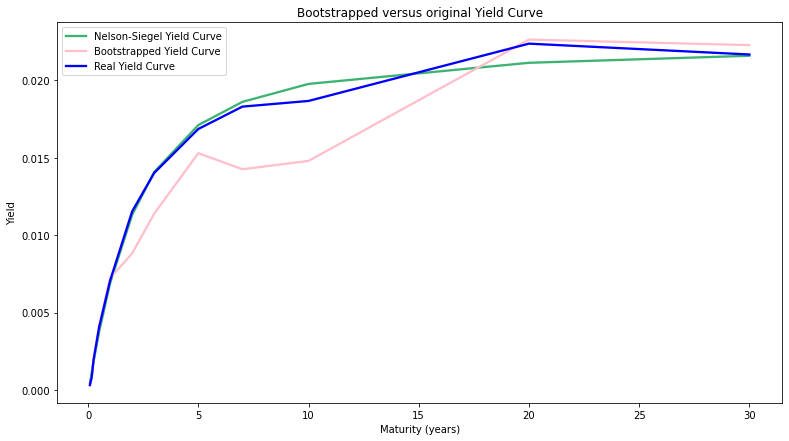

In [247]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

yield_ = np.array(df['Yield']/100)
t_years = df['Years to Maturity']
yearly_yields = []

ns_source_test = ols_nelson_siegel(t_years, yield_, tau=1.0)
beta1 = ns_source_test[0]
beta2 = ns_source_test[1]
beta3 = ns_source_test[2]
tau = ns_source_test[3]

for i in t_years:
    array = beta1 + beta2*((1-np.exp(-i/tau))/(i/tau))+beta3*(((1-np.exp(-i/tau))/(i/tau))-(np.exp(-i/tau)))
    yearly_yields.append(array)

ax.plot(t_years, yearly_yields, label = "Nelson-Siegel Yield Curve", color = 'mediumseagreen', linewidth = 2.3)
fig.set_size_inches(13, 7)
ax.plot(yield_curve.index,yield_curve, label = "Bootstrapped Yield Curve", color = 'pink', linewidth = 2.3)
real_yields = pd.DataFrame(df["Yield"]/100)
real_yields = real_yields.set_index(df['Years to Maturity'])
ax.plot(real_yields, label = "Real Yield Curve", color = 'blue', linewidth = 2.3)
ax.set_title("Bootstrapped versus original Yield Curve")
ax.set_ylabel("Yield")
ax.set_xlabel("Maturity (years)")
ax.legend()

In [248]:
slope_between_1y_and_2y = (yield_curve['Bootstrapped Yields'].iloc[5] -  yield_curve['Bootstrapped Yields'].iloc[4])/(df['Weeks to Maturity'].iloc[5] -  df['Weeks to Maturity'].iloc[4])

In [249]:
slope_between_1y_and_2y

3.0284660437026407e-05

In [250]:
yield_bootstrap_one_y_2_weeks = yield_curve['Bootstrapped Yields'].iloc[4] + slope_between_1y_and_2y*(2)

In [251]:
yield_bootstrap_one_y_2_weeks

0.00728133498995575

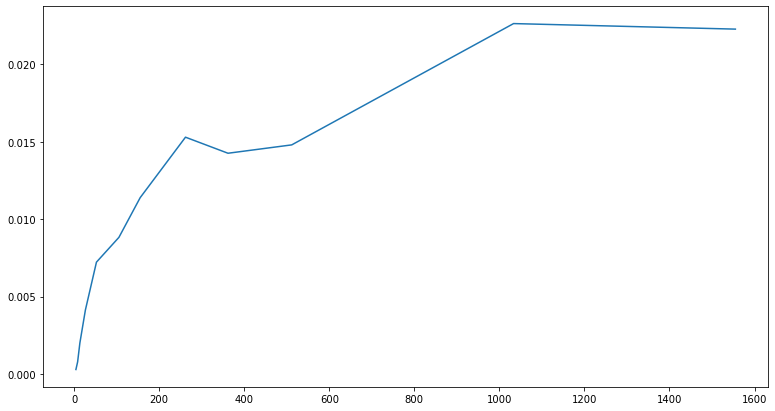

In [252]:
yield_curve_plot = plot(df['Weeks to Maturity'], yield_curve)

**Price for a hypothetical semi-annual coupon bond with one year two weeks to maturity and a coupon rate of 10%.**

In [271]:
price_bootstrap_one_y_2_weeks = get_price_from_yield(yield_bootstrap_one_y_2_weeks, 100, 2, 5, 1)

In [272]:
print("Bootstrap Price: " + str(price_bootstrap_one_y_2_weeks))

Bootstrap Price: 109.22147750001557


**Price for a hypothetical semi-annual floating-rate coupon bond with two years three months to maturity. The floating coupon rate is tied to the six-month LIBOR interest rate**

In [282]:
slope_between_2y_and_3y = (yield_curve['Bootstrapped Yields'].iloc[6] -  yield_curve['Bootstrapped Yields'].iloc[5])/(df['Weeks to Maturity'].iloc[6] -  df['Weeks to Maturity'].iloc[5])

In [279]:
yield_bootstrap_2_y_3m = yield_curve['Bootstrapped Yields'].iloc[5] + slope_between_2y_and_3y*(12)

In [284]:
price_bootstrap_two_y_3_months = get_price_from_yield(y = yield_bootstrap_2_y_3m, F = 100, m = 2, c = LIBOR_yield*100, n = 2)

In [285]:
print("Bootstrap Price: " + str(price_bootstrap_two_y_3_months))

Bootstrap Price: 99.05182811959419


**Duration for a hypothetical semi-annual coupon bond with one year two weeks to maturity and a coupon rate of 10%.**

In [287]:
get_duration(yield_bootstrap_one_y_2_weeks, F = 100, m = 2, c = 5, n = 2)

0.9771937589178683

**Duration for a hypothetical semi-annual floating-rate coupon bond with two years three months to maturity. The floating coupon rate is tied to the six-month LIBOR interest rate**

In [288]:
get_duration(yield_bootstrap_2_y_3m, F = 100, m = 2, c = LIBOR_yield*100, n = 4)

1.9930282450384371